<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

**Задача проекта:** нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. 

Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

Построим модель с предельно большим значением *F1*-меры. Нужно довести метрику до 0.59. 

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier # решающее дерево
from sklearn.ensemble import RandomForestClassifier # случаный лес
from sklearn.linear_model import LogisticRegression # логистическая регрессия
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.utils import shuffle

In [2]:
if os.path.exists('/datasets/churn.csv'):
    df = pd.read_csv('/datasets/churn.csv')
else:
    df = pd.read_csv('churn.csv')
display(df)

Выведем общую информацию по таблице.

In [3]:
df.info()

Переименуем колонки.

In [5]:
df = df.rename(columns={'RowNumber': 'row_number', 'CustomerId': 'customer_id', \
                   'Surname': 'surname', 'CreditScore': 'credit_score', \
                   'Geography': 'geography', 'Gender': 'gender', \
                   'Age': 'age', 'Tenure': 'tenure', 'Balance': 'balance', \
                   'NumOfProducts': 'num_of_products', 'HasCrCard': 'has_cr_card', 'IsActiveMember': 'is_active_member', \
                   'EstimatedSalary': 'estimated_salary', 'Exited': 'exited'})

Построим гистограммы по каждому столбцу.

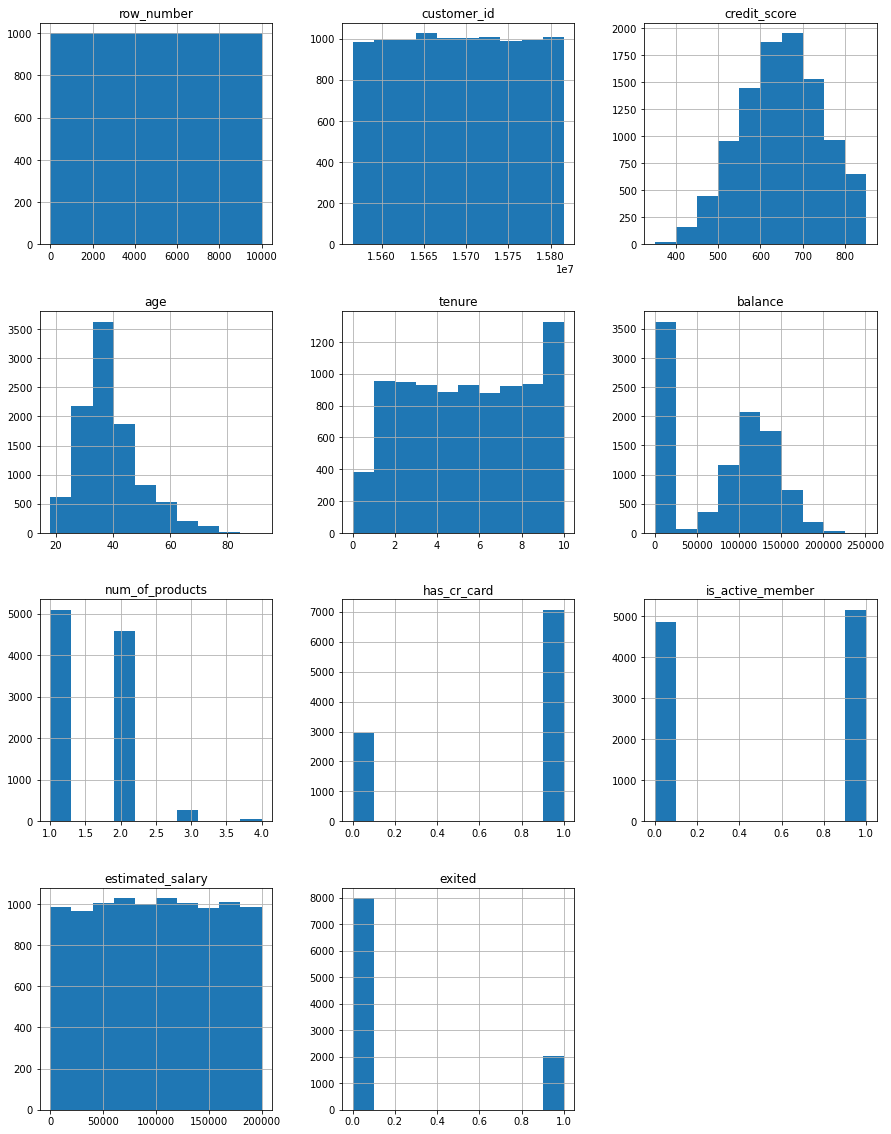

In [6]:
df.hist(figsize=(15, 20));

In [7]:
df.describe().T

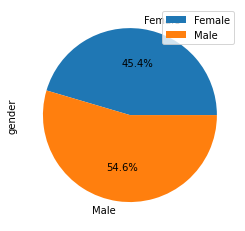

In [8]:
pt_gender = pd.pivot_table(df, index=['gender'],
                   values=['customer_id'],
                   aggfunc='count')
pt_gender.columns = ['gender']
pt_gender.plot(kind='pie', y='gender', autopct='%1.1f%%');

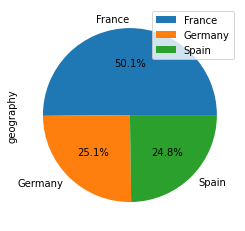

In [9]:
pt_countruies = pd.pivot_table(df, index=['geography'],
                   values=['customer_id'],
                   aggfunc='count')
pt_countruies.columns = ['geography']
pt_countruies.plot(kind='pie', y='geography', autopct='%1.1f%%');

В данных есть пропуски по столбцу tenure. Заменим их на -1.

In [10]:
df['tenure'] = df['tenure'].fillna(-1)

Удалим столбцы row_number, customer_id, surname поскольку они не информативны для модели имогут исказить результаты.

In [11]:
df = df.drop(['row_number', 'customer_id', 'surname'], axis=1)

Медианное число лет, которое человек является клиентом банка - 5 лет. Медианный возраст клиентов банка - 37 лет. Мужчин 55%, женщин 45%. Большая часть клиентов из Франции - 50%, из Германии и Испании примерно поровну: по ~ 25%.
Медианное значение кредитного рейтинга - 652. 
Баланс на счетах у многих клиентов нулевой, возможно часть из них - это ушедшие клиенты. Медианная предполагаемая зарплата клиентов ~ 100 тыс.руб.
Медианное значение количества продуктов банка, используемых клиентом - 1.
Количество клиентов, у которых есть кредитные карты (~ 7000), больше чем в два раза количества клиентов без кредитной карты (~ 3000).
Активных клиентов чуть больше половины. Ушедших ~20%.

## Исследование задачи

Преобразуем категориальные признаки в численные.

In [12]:
df_ohe = pd.get_dummies(df, drop_first=True)

Отводим 60% данных под обучающую выборку и по 20% под валидационную и тестовую выборки. 

In [13]:
df_train, df_test_common = train_test_split(df_ohe, test_size=0.4, random_state=12345, stratify=df['exited'])
df_test, df_valid = train_test_split(df_test_common, test_size=0.5, random_state=12345, stratify=df_test_common['exited'])

In [14]:
round(df_train.shape[0] / df.shape[0] * 100)

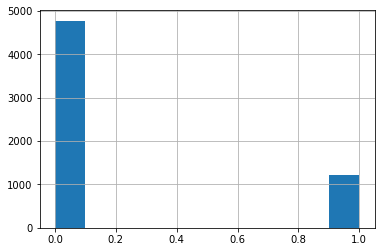

In [15]:
df_train['exited'].hist();

In [16]:
round(df_test.shape[0] / df.shape[0] * 100)

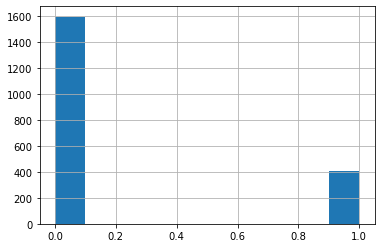

In [17]:
df_test['exited'].hist();

In [18]:
round(df_valid.shape[0] / df.shape[0] * 100)

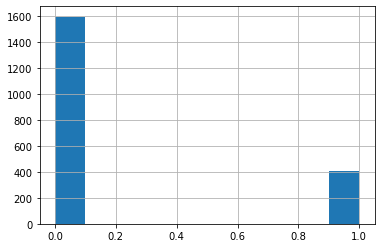

In [19]:
df_valid['exited'].hist();

Деление на выборки выполнено корректно, с учетом дисбаланса классов.

Поскольку задача состоит в том, чтобы предсказать уход клиента - это задача классификации. Исследуем три модели: решающее дерево, случайный лес и логистическая регрессия без учета дисбаланса классов.

In [20]:
features_train = df_train.drop(['exited'], axis=1)
target_train = df_train['exited'] 
features_valid = df_valid.drop(['exited'], axis=1)
target_valid = df_valid['exited'] 
features_test = df_test.drop(['exited'], axis=1)
target_test = df_test['exited'] 

Приведем признаки к единому масштабу.

In [26]:
scaler = StandardScaler()

cols_to_scale=['credit_score','tenure','balance','num_of_products','estimated_salary','age']

scaler.fit(features_train[cols_to_scale])
features_train[cols_to_scale] = scaler.transform(features_train[cols_to_scale])
features_valid[cols_to_scale] = scaler.transform(features_valid[cols_to_scale])
features_test[cols_to_scale] = scaler.transform(features_test[cols_to_scale])

In [28]:
# решающее дерево
best_depth = 0
best_f1_score_dt = 0
best_auc_roc_dt = 0
best_model_dt = None
for depth in range(1, 12):
    
    model_dt = DecisionTreeClassifier(random_state=12345, max_depth=depth) # обучение модели с заданной глубиной дерева
    model_dt.fit(features_train, target_train) # обучение модели на тренировочной выборке
    predicted_valid_dt = model_dt.predict(features_valid)
    
    f1_score_dt = f1_score(target_valid, predicted_valid_dt)
    
    probabilities_valid_dt = model_dt.predict_proba(features_valid)
    probabilities_one_valid_dt = probabilities_valid_dt[:, 1]
    auc_roc_dt = roc_auc_score(target_valid, probabilities_one_valid_dt)

    if f1_score_dt > best_f1_score_dt:
        best_model_dt = model_dt
        best_f1_score_dt = f1_score_dt # наилучшее значение f1-меры на валидационных данных
        best_depth = depth
        best_auc_roc_dt = auc_roc_dt

print("F1-мера наилучшей модели на валидационной выборке:", best_f1_score_dt)
print("Глубина дерева:", best_depth)
print("Auc-roc:", best_auc_roc_dt)

In [29]:
%%time

# случайный лес
best_f1_score_rf = 0
best_est = 0
best_depth = 0
best_auc_roc_rf = 0
best_model_rf = None
for est in range(1, 11):
    for depth in range(1, 11):
        model_rf = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth = depth) # обучение модели с заданным количеством деревьев
        model_rf.fit(features_train, target_train) # обучение модели на тренировочной выборке
        predicted_valid_rf = model_rf.predict(features_valid)
        f1_score_rf = f1_score(target_valid, predicted_valid_rf) # расчет качества модели на валидационной выборке
        
        probabilities_valid_rf = model_rf.predict_proba(features_valid)
        probabilities_one_valid_rf = probabilities_valid_rf[:, 1]
        auc_roc_rf = roc_auc_score(target_valid, probabilities_one_valid_rf)
    
        if f1_score_rf > best_f1_score_rf:
            best_f1_score_rf = f1_score_rf #  сохраните наилучшее значение f1-меры на валидационных данных
            best_est = est
            best_depth = depth
            best_model_rf = model_rf
            best_auc_roc_rf = auc_roc_rf

print("F1-мера наилучшей модели на валидационной выборке:", best_f1_score_rf)
print("количество деревьев:", best_est)
print("Глубина дерева:", best_depth)
print("Auc-roc:", best_auc_roc_rf)

In [30]:
# логистическая регрессия
model_lr = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=100) # обучение модели с заданным количеством деревьев
model_lr.fit(features_train, target_train) # обучение модели на тренировочной выборке
predicted_valid_lr = model_lr.predict(features_valid)

probabilities_valid_lr = model_lr.predict_proba(features_valid)
probabilities_one_valid_lr = probabilities_valid_lr[:, 1]

print("F1-мера модели на валидационной выборке:", f1_score(target_valid, predicted_valid_lr))
print("Auc-roc:", roc_auc_score(target_valid, probabilities_one_valid_lr))
print("Максимальное количество итераций обучения:", 100)

model_lr = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000) # обучение модели с заданным количеством деревьев
model_lr.fit(features_train, target_train) # обучение модели на тренировочной выборке
predicted_valid_lr = model_lr.predict(features_valid)

probabilities_valid_lr = model_lr.predict_proba(features_valid)
probabilities_one_valid_lr = probabilities_valid_lr[:, 1]

print("F1-мера модели на валидационной выборке:", f1_score(target_valid, predicted_valid_lr))
print("Auc-roc:", roc_auc_score(target_valid, probabilities_one_valid_lr))
print("Максимальное количество итераций обучения:", 1000)

Изменение количества итераций для линейной регрессии не ведет к улучшению точности.

Случайный лес с 1 деревом и глубиной дерева 4 дал значение f1-меры 0,56 - это самый высокий показатель и он не достиг требуемой отметки 0,59. Решающее дерево показало результаты похуже: f1-мера 0,55. У логистической регрессии значения самые плохие. Обучим модели с учетом дисбаланса классов.
При этом значение AUC-ROC самое высокое (0,80 против 0,75) у модели решающего дерева.

## Борьба с дисбалансом

Попробуем применить тактику апсэмплинга и даунсэмплинга, чтобы выровнять дисбаланс классов. Сначала увеличим значения ушедших клиентов в 2 раза, потом уменьшим значения оставшихся клиентов в 2 раза. Таким образом, получим соотношение близкое к 50 на 50.

In [38]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 2)

features_train_b, target_train_b = downsample(features_upsampled, target_upsampled, 0.5)

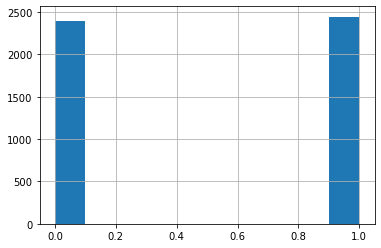

In [39]:
target_train_b.hist();

Теперь дисбаланс классов отсутствует. Попробуем обучить модели на таких данных и посмотрим, изменятся ли показатели.

Для начала приведем данные к единому масштабу.

In [40]:
scaler.fit(features_train_b[cols_to_scale])
features_train_b[cols_to_scale] = scaler.transform(features_train_b[cols_to_scale])

Проверим все модели из предыдущего шага.

In [42]:
# решающее дерево
best_depth = 0
best_f1_score_dt = 0
best_auc_roc_dt = 0
best_model_dt = None
for depth in range(1, 12):
    
    model_dt = DecisionTreeClassifier(random_state=12345, max_depth=depth) # обучение модели с заданной глубиной дерева
    model_dt.fit(features_train_b, target_train_b) # обучение модели на тренировочной выборке
    predicted_valid_dt = model_dt.predict(features_valid)
    
    f1_score_dt = f1_score(target_valid, predicted_valid_dt)
    
    probabilities_valid_dt = model_dt.predict_proba(features_valid)
    probabilities_one_valid_dt = probabilities_valid_dt[:, 1]
    auc_roc_dt = roc_auc_score(target_valid, probabilities_one_valid_dt)

    if f1_score_dt > best_f1_score_dt:
        best_model_dt = model_dt
        best_f1_score_dt = f1_score_dt # наилучшее значение f1-меры на валидационных данных
        best_depth = depth
        best_auc_roc_dt = auc_roc_dt

print("F1-мера наилучшей модели на валидационной выборке:", best_f1_score_dt)
print("Глубина дерева:", best_depth)
print("Auc-roc:", best_auc_roc_dt)

In [43]:
%%time

# случайный лес
best_f1_score_rf = 0
best_est = 0
best_depth = 0
best_auc_roc_rf = 0
best_model_rf_b = None
for est in range(1, 11):
    for depth in range(1, 11):
        model_rf = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth = depth) # обучение модели с заданным количеством деревьев
        model_rf.fit(features_train_b, target_train_b) # обучение модели на тренировочной выборке
        predicted_valid_rf = model_rf.predict(features_valid)
        f1_score_rf = f1_score(target_valid, predicted_valid_rf) # расчет качества модели на валидационной выборке
        
        probabilities_valid_rf = model_rf.predict_proba(features_valid)
        probabilities_one_valid_rf = probabilities_valid_rf[:, 1]
        auc_roc_rf = roc_auc_score(target_valid, probabilities_one_valid_rf)
    
        if f1_score_rf > best_f1_score_rf:
            best_f1_score_rf = f1_score_rf #  сохраните наилучшее значение f1-меры на валидационных данных
            best_est = est
            best_depth = depth
            best_model_rf_b = model_rf
            best_auc_roc_rf = auc_roc_rf

print("F1-мера наилучшей модели на валидационной выборке:", best_f1_score_rf)
print("количество деревьев:", best_est)
print("Глубина дерева:", best_depth)
print("Auc-roc:", best_auc_roc_rf)

In [44]:
# логистическая регрессия
model_lr = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000) # обучение модели с заданным количеством деревьев
model_lr.fit(features_train_b, target_train_b) # обучение модели на тренировочной выборке
predicted_valid_lr = model_lr.predict(features_valid)

probabilities_valid_lr = model_lr.predict_proba(features_valid)
probabilities_one_valid_lr = probabilities_valid_lr[:, 1]

print("F1-мера модели на валидационной выборке:", f1_score(target_valid, predicted_valid_lr))
print("Auc-roc:", roc_auc_score(target_valid, probabilities_one_valid_lr))
print("Максимальное количество итераций обучения:", 1000)

F1-мера уменьшилась незначительно для модели решающего дерева, дала прирост с 0,56 до 0,59 для модели случайного леса, и дала очень хороший прирост для логистической регресии с 0,29 до 0,46. Лучший показатель также дает модель случайного леса с параметрами: 9 деревьев и глубина дерева - 8.

AUC-ROC также самый высокий у модели случайного леса 0,84, далее идет решающее дерево - 0,81 и логистическая регрессия - 0,75. То есть этот показатель незначительно улучшился в модели решающего дерева, сильно прибавил для случайного леса и почти не изменился для логистической регрессии.

Попробуем создать модели с признаком class_weight='balanced'.

In [45]:
# решающее дерево
best_depth = 0
best_f1_score_dt = 0
best_auc_roc_dt = 0
best_model_dt = None
for depth in range(1, 12):
    
    model_dt = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced') # обучение модели с заданной глубиной дерева
    model_dt.fit(features_train, target_train) # обучение модели на тренировочной выборке
    predicted_valid_dt = model_dt.predict(features_valid)
    
    f1_score_dt = f1_score(target_valid, predicted_valid_dt)
    
    probabilities_valid_dt = model_dt.predict_proba(features_valid)
    probabilities_one_valid_dt = probabilities_valid_dt[:, 1]
    auc_roc_dt = roc_auc_score(target_valid, probabilities_one_valid_dt)

    if f1_score_dt > best_f1_score_dt:
        best_model_dt = model_dt
        best_f1_score_dt = f1_score_dt # наилучшее значение f1-меры на валидационных данных
        best_depth = depth
        best_auc_roc_dt = auc_roc_dt

print("F1-мера наилучшей модели на валидационной выборке:", best_f1_score_dt)
print("Глубина дерева:", best_depth)
print("Auc-roc:", best_auc_roc_dt)

Результаты решающего дерева стали хуже, чем в предыдущих подходах: 0,54 против 0,55.

In [46]:
%%time

# случайный лес
best_f1_score_rf = 0
best_est = 0
best_depth = 0
best_auc_roc_rf = 0
best_model_rf_balanced = None
for est in range(1, 11):
    for depth in range(1, 11):
        model_rf = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth = depth, class_weight='balanced') # обучение модели с заданным количеством деревьев
        model_rf.fit(features_train, target_train) # обучение модели на тренировочной выборке
        predicted_valid_rf = model_rf.predict(features_valid)
        f1_score_rf = f1_score(target_valid, predicted_valid_rf) # расчет качества модели на валидационной выборке
        
        probabilities_valid_rf = model_rf.predict_proba(features_valid)
        probabilities_one_valid_rf = probabilities_valid_rf[:, 1]
        auc_roc_rf = roc_auc_score(target_valid, probabilities_one_valid_rf)
    
        if f1_score_rf > best_f1_score_rf:
            best_f1_score_rf = f1_score_rf #  сохраните наилучшее значение f1-меры на валидационных данных
            best_est = est
            best_depth = depth
            best_model_rf_balanced = model_rf
            best_auc_roc_rf = auc_roc_rf

print("F1-мера наилучшей модели на валидационной выборке:", best_f1_score_rf)
print("количество деревьев:", best_est)
print("Глубина дерева:", best_depth)
print("Auc-roc:", best_auc_roc_rf)

Результат 0,59 лучше, чем в первой модели без учета дисбаланса - 0,56. И чуть лучше предыдущей модели.

In [47]:
# логистическая регрессия
model_lr = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000, class_weight='balanced') # обучение модели с заданным количеством деревьев
model_lr.fit(features_train, target_train) # обучение модели на тренировочной выборке
predicted_valid_lr = model_lr.predict(features_valid)

probabilities_valid_lr = model_lr.predict_proba(features_valid)
probabilities_one_valid_lr = probabilities_valid_lr[:, 1]

print("F1-мера модели на валидационной выборке:", f1_score(target_valid, predicted_valid_lr))
print("Auc-roc:", roc_auc_score(target_valid, probabilities_one_valid_lr))
print("Максимальное количество итераций обучения:", 1000)

Самый лучший результат f1-меры для логистической регрессии получился при использовании параметра class_weihgt='balanced' - 0,47, но все равно это значение значительно ниже целевого в 0,59.

Таким образом, наилучшее значение f1-меры у модели слчайного леса и это самый лучший показатель для этой модели. AUC-ROC для случайного леса увеличился 0,84, у решающего дерева уменьшился - 0,79 и для логистической регрессии почти не поменялся - 0,75.

## Тестирование модели

Проверим лучшие модели по результатам исследования - это модели случайного леса с балансировкой. Проверим их на тестовых данных.

In [48]:
predicted_test_rf = best_model_rf_b.predict(features_test)
f1_score_rf = f1_score(target_test, predicted_test_rf) # расчет качества модели на тестовой выборке
        
probabilities_test_rf = best_model_rf_balanced.predict_proba(features_test)
probabilities_one_test_rf = probabilities_test_rf[:, 1]
auc_roc_rf = roc_auc_score(target_test, probabilities_one_test_rf)

print("F1-мера наилучшей модели на тестовой выборке:", f1_score_rf)
print("Auc-roc:", auc_roc_rf)

На тестовых данных f1-мера снизилась до 0,57. Проверим как отработает вторая модель: случаный лес с параметром class_weihgt='balanced'.

In [49]:
predicted_test_rf = best_model_rf_balanced.predict(features_test)
f1_score_rf = f1_score(target_test, predicted_test_rf) # расчет качества модели на тестовой выборке
        
probabilities_test_rf = best_model_rf_balanced.predict_proba(features_test)
probabilities_one_test_rf = probabilities_test_rf[:, 1]
auc_roc_rf = roc_auc_score(target_test, probabilities_one_test_rf)

print("F1-мера наилучшей модели на тестовой выборке:", f1_score_rf)
print("Auc-roc:", auc_roc_rf)

Здесь значение f1-меры намного лучше, при этом AUC-ROC равны. Построим график AUC-ROC для лучшей модели.

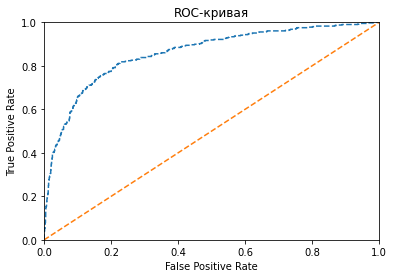

In [51]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test_rf)

plt.figure()

plt.plot(fpr, tpr, linestyle='--')

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

#  применим функции plt.xlim() и plt.ylim(), чтобы
#   установить границы осей от 0 до 1 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# применим функции plt.xlabel() и plt.ylabel(), чтобы
#  подписать оси "False Positive Rate" и "True Positive Rate" 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# добавим к графику заголовок "ROC-кривая" функцией plt.title() 
plt.title('ROC-кривая')

plt.show()

# Выводы

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Были проанализированы исторические данные о поведении клиентов и расторжении договоров с банком.

Медианное число лет, которое человек является клиентом банка - 5 лет. Медианный возраст клиентов банка - 37 лет. Мужчин 55%, женщин 45%. Большая часть клиентов из Франции - 50%, из Германии и Испании примерно поровну: по ~ 25%. Медианное значение кредитного рейтинга - 652. Баланс на счетах у многих клиентов нулевой, возможно часть из них - это ушедшие клиенты. Медианная предполагаемая зарплата клиентов ~ 100 тыс.руб. Медианное значение количества продуктов банка, используемых клиентом - 1. Количество клиентов, у которых есть кредитные карты (~ 7000), больше чем в два раза количества клиентов без кредитной карты (~ 3000). Активных клиентов чуть больше половины. Ушедших ~20%.

В исходных данных есть дисбаланс распредения между ушедшими и текущими клиентами: доля ушедших клиентов 20%. 

Были построены несколько вариантов три модели для предсказывания выбора тарифа: решающее дерево, случайный лес и логистическая регрессия. Сначала без учета дисбаланса данных, затем с применением разных способов борьбы с дисбалансом. Лучше всего с задачей предсказания ухода клиентов справилась модель случайный лес лучаный лес с 10 деревьями и глубиной дерева 9 и параметром class_weihgt='balanced'. На тестовых данных f1-мера равна 0.63, что выше порогового показателя 0.59. Значения AUC-ROC этой модели 0,85. Модель со случайным распределением дает значение AUC-ROC 0,5. 0,85 значительно выше 0,5, при условии, что этот показатель не превышает 1, модель адекватна.